In [1]:
#Same as the RNN.ipynb except the images are cropped to only include the subjects face
from matplotlib import pyplot as plt
from mtcnn.mtcnn import MTCNN
from matplotlib.patches import Rectangle
from PIL import Image
from tensorflow.keras.preprocessing import image
from scipy.spatial.distance import cosine
from keras.utils.layer_utils import get_source_inputs
from tensorflow import keras
from imutils import paths
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import os

In [11]:
IMG_W = 224
IMG_H = 224
BATCH_SIZE = 64
EPOCHS = 50

MAX_SEQ_LENGTH = 100
NUM_FEATURES = 2048

In [3]:
df1 = pd.read_csv("../Data/mirror-data2.csv")
df1 = df1[df1.Action != ("Talking" or "talking")]
df1.head()

,Action,video-name,yawn-start
0,Normal,1-FemaleNoGlasses-Normal.avi,0
2,Yawning,1-FemaleNoGlasses-Yawning.avi,50
3,Normal,2-FemaleNoGlasses-Normal.avi,0
5,Yawning,2-FemaleNoGlasses-Yawning.avi,375
6,Normal,3-FemaleGlasses-Normal.avi,0


In [4]:
def extract_face_from_image(frame, required_size=(224, 224)):
    # load image and detect faces
    image = frame
    detector = MTCNN()
    faces = detector.detect_faces(image)
  
    # extract the bounding box from the requested face
    x1, y1, width, height = faces[0]['box']
    x2, y2 = x1 + width, y1 + height

    # extract the face
    face_boundary = image[y1:y2, x1:x2]

    # resize pixels to the model size
    face_image = Image.fromarray(face_boundary)
    face_image = face_image.resize(required_size)
    face_array = np.asarray(face_image)
    

    return face_array

def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]


def load_video(frames,  resize=(IMG_H, IMG_W)):
    
    frames = []

    
    
    for frame in frames:

        frame = extract_face_from_image(frame)
        frame = cv2.resize(frame, resize)
        frame = frame[:, :, [2, 1, 0]]
        frames.append(frame)
        

        
    
    return np.array(frames)


In [5]:
def build_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_H, IMG_W, 3),
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((IMG_H, IMG_W, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()

In [6]:
label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(df1['Action'])
)
print(label_processor.get_vocabulary())

['Normal', 'Talking&Yawning', 'Yawning', 'talking']


In [7]:
i = 0
dfTrain = pd.DataFrame()
dfTest = pd.DataFrame()

while i<len(df1):
    if i%5==0:
        dfTest = dfTest.append(df1.iloc[[i]])
    else :
        dfTrain = dfTrain.append(df1.iloc[[i]])

    i+=1

In [8]:
def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["video-name"].values.tolist()
    start_nums = df["yawn-start"].values.tolist()
    # print(video_paths)
    labels = df["Action"].values
    labels = label_processor(labels[..., None]).numpy()

    # `frame_masks` and `frame_features` are what we will feed to our sequence model.
    # `frame_masks` will contain a bunch of booleans denoting if a timestep is
    # masked with padding or not.
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video.
    for idx, path in enumerate(video_paths):
        videoName = path
        number = start_nums[idx]
        frames = []

        while(len(frames)<=MAX_SEQ_LENGTH):
            path = "../Data/VideoFrames/"+videoName+"/"+videoName+"_"+f"{number:03}"+".jpg"
            frames.append(image.load_img(path, target_size=(224, 224, 3)))
            number+=1
        print(path)


        frames = load_video(frames)
        frames = frames[None, ...]
        # Initialize placeholders to store the masks and features of the current video.
        temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )
        # Extract features from the frames of the current video.
        
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                temp_frame_features[i, j, :] = feature_extractor.predict(
                    batch[None, j, :]
                )
            temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

        frame_features[idx,] = temp_frame_features.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()
        

    return (frame_features, frame_masks), labels


train_data, train_labels = prepare_all_videos(dfTrain, "../Data/Mirror")
test_data, test_labels = prepare_all_videos(dfTest, "../Data/Mirror")

print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {train_data[1].shape}")

../Data/VideoFrames/1-FemaleNoGlasses-Yawning.avi/1-FemaleNoGlasses-Yawning.avi_150.jpg
../Data/VideoFrames/2-FemaleNoGlasses-Normal.avi/2-FemaleNoGlasses-Normal.avi_100.jpg
../Data/VideoFrames/2-FemaleNoGlasses-Yawning.avi/2-FemaleNoGlasses-Yawning.avi_475.jpg
../Data/VideoFrames/3-FemaleGlasses-Normal.avi/3-FemaleGlasses-Normal.avi_100.jpg
../Data/VideoFrames/4-FemaleGlasses-Normal.avi/4-FemaleGlasses-Normal.avi_100.jpg
../Data/VideoFrames/4-FemaleGlasses-Yawning.avi/4-FemaleGlasses-Yawning.avi_110.jpg
../Data/VideoFrames/5-FemaleGlasses-Normal.avi/5-FemaleGlasses-Normal.avi_100.jpg
../Data/VideoFrames/5-FemaleGlasses-Yawning.avi/5-FemaleGlasses-Yawning.avi_240.jpg
../Data/VideoFrames/6-FemaleNoGlasses-Yawning.avi/6-FemaleNoGlasses-Yawning.avi_220.jpg
../Data/VideoFrames/7-FemaleGlasses-Normal.avi/7-FemaleGlasses-Normal.avi_100.jpg
../Data/VideoFrames/7-FemaleGlasses-Yawning.avi/7-FemaleGlasses-Yawning.avi_185.jpg
../Data/VideoFrames/8-FemaleGlasses-Normal.avi/8-FemaleGlasses-Normal.

In [12]:
# Utility for our sequence model.
def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    x = keras.layers.GRU(16, return_sequences=True)(
        frame_features_input, mask=mask_input
    )
    x = keras.layers.GRU(8)(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(8, activation="relu")(x)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Adam(epsilon=1, learning_rate=5), metrics=["accuracy"]
    )
    return rnn_model


# Utility for running experiments.
def run_experiment():
    filepath = "./video_classifier"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    seq_model = get_sequence_model()
    history = seq_model.fit(
        [train_data[0], train_data[1]],
        train_labels,
        validation_split=0.3,
        epochs=EPOCHS,
        callbacks=[checkpoint],
    )

    seq_model.load_weights(filepath)
    _, accuracy = seq_model.evaluate([test_data[0], test_data[1]], test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, seq_model


_, sequence_model = run_experiment()

Epoch 1/50
4/4 [==============================] - ETA: 0s - loss: 1.3401 - accuracy: 0.3821
Epoch 1: val_loss improved from inf to 1.23183, saving model to .\video_classifier
4/4 [==============================] - 10s 1s/step - loss: 1.3401 - accuracy: 0.3821 - val_loss: 1.2318 - val_accuracy: 0.4528
Epoch 2/50
4/4 [==============================] - ETA: 0s - loss: 1.1778 - accuracy: 0.4797
Epoch 2: val_loss improved from 1.23183 to 1.07562, saving model to .\video_classifier
4/4 [==============================] - 1s 155ms/step - loss: 1.1778 - accuracy: 0.4797 - val_loss: 1.0756 - val_accuracy: 0.4528
Epoch 3/50
4/4 [==============================] - ETA: 0s - loss: 1.0536 - accuracy: 0.4797
Epoch 3: val_loss improved from 1.07562 to 0.97891, saving model to .\video_classifier
4/4 [==============================] - 1s 152ms/step - loss: 1.0536 - accuracy: 0.4797 - val_loss: 0.9789 - val_accuracy: 0.4528
Epoch 4/50
4/4 [==============================] - ETA: 0s - loss: 0.9826 - accurac

In [13]:
image = plt.imread('../Data/VideoFrames/17-FemaleSunGlasses-Normal.avi/17-FemaleSunGlasses-Normal.avi_000.jpg')
detector = MTCNN()

faces = detector.detect_faces(image)
for face in faces:
  print(face)

1/1 [==============================] - 0s 138ms/step
{'box': [175, 121, 223, 291], 'confidence': 0.9996501207351685, 'keypoints': {'left_eye': (272, 242), 'right_eye': (367, 238), 'nose': (342, 278), 'mouth_left': (282, 344), 'mouth_right': (363, 340)}}


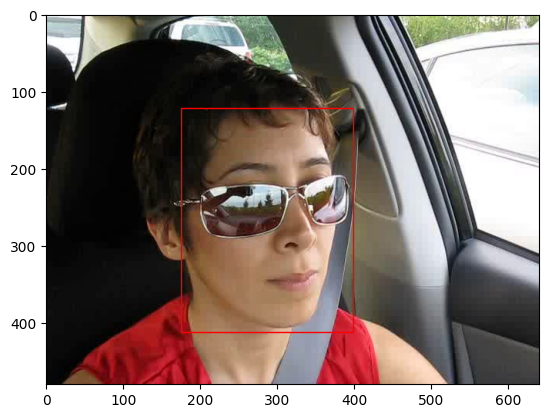

In [36]:
def highlight_faces(image_path, faces):
  # display image
  image = plt.imread(image_path)
  plt.imshow(image)

  ax = plt.gca()

  # for each face, draw a rectangle based on coordinates
  for face in faces:
    x, y, width, height = face['box']
    face_border = Rectangle((x, y), width, height,
                          fill=False, color='red')
    ax.add_patch(face_border)
  plt.show()

highlight_faces('../Data/VideoFrames/17-FemaleSunGlasses-Normal.avi/17-FemaleSunGlasses-Normal.avi_000.jpg', faces)


1/1 [==============================] - 0s 132ms/step


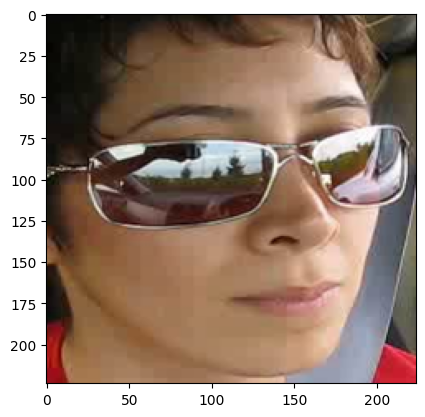

In [5]:
def extract_face_from_image(image_path, required_size=(224, 224)):
  # load image and detect faces
  image = plt.imread(image_path)
  detector = MTCNN()
  faces = detector.detect_faces(image)

  face_images = []

  for face in faces:
    # extract the bounding box from the requested face
    x1, y1, width, height = face['box']
    x2, y2 = x1 + width, y1 + height

    # extract the face
    face_boundary = image[y1:y2, x1:x2]

    # resize pixels to the model size
    face_image = Image.fromarray(face_boundary)
    face_image = face_image.resize(required_size)
    face_array = np.asarray(face_image)
    face_images.append(face_array)

  return face_images

extracted_face = extract_face_from_image('../Data/VideoFrames/17-FemaleSunGlasses-Normal.avi/17-FemaleSunGlasses-Normal.avi_000.jpg')

# Display the first face from the extracted faces
plt.imshow(extracted_face[0])
plt.show()

In [ ]:
def get_model_scores(faces):
  samples = asarray(faces, 'float32')

  # prepare the data for the model
  samples = preprocess_input(samples, version=2)

  # create a vggface model object
  model = VGGFace(model='resnet50',
      include_top=False,
      input_shape=(224, 224, 3),
      pooling='avg')

  # perform prediction
  return model.predict(samples)

faces = [extract_face_from_image(image_path)
         for image_path in ['iacocca_1.jpg', 'iacocca_2.jpg']]

model_scores = get_model_scores(faces)